# Sect 37: Intro to Time Series

- online-ds-pt-100719pt 
- 05/05/20

## Learning Objectives:

- Learn how to load in timeseries data into pandas
- Learn how to plot timeseries in pandas
- Learn how to resample at different time frequencies
- Learn about types of time series trends and how to remove them.
- Learn about seasonal decomposition

## Questions?

1. From [Visualizing Time Series Data - Lab](https://github.com/learn-co-students/dsc-visualizing-time-series-data-lab-online-ds-pt-100719/tree/solution) Grouper and .groupby()  ….almost understand the difference but … not 100%:
    - What is the output ? 
    - How to ‘see it’  ..

```python
groups_monthly = yr_1990.groupby(pd.Grouper(freq='M'))
# Outputs:
<pandas.core.groupby.generic.DataFrameGroupBy object at 0x0000019376272AC8>
```


<br>

2. ...we access [1] through the .values… while concatonating?
```python
# Add each month to DataFrame as a column
months_1990 = pd.concat([pd.DataFrame(x[1].values) for x in groups_monthly], axis=1)
months_df = pd.DataFrame(months_1990)
```
3. Parameters for various functions: (examples below)
    - How to select the appropriate period using .diff()
    - How to select the appropriate window using .rolling()
    - How to select the appropriate halflife using ..ewm()
    
    

4. Interpreting results from Dickey Fuller test… and understanding the object  in order to understand the code behind obtaining it.
```python
# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print(dftest)
```



5. Do you just keep layering on the various methods to remove trends?  Is there a helpful order? 



6. Is log-transformed the same as original?  



7. I understand we need the data to be stationary for modeling… but when removing trends, it seems very diluted compared to the original version. The example below is from the [last lab](https://github.com/learn-co-students/dsc-removing-trends-lab-online-ds-pt-100719/tree/solution) uses the exponential rolling mean and differencing….  
    - Is there a way to reverse it back to help interpret results/explain model?
    ```python
data_diff = data_minus_exp_roll_mean.diff(periods=12)
```

# Intro to Time Series

## References

- [Pandas Timeseries Documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)
- ['Timeseries Offset Aliases'](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases)
- [Anchored Offsets](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets)


- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html

## Working with Time Series

In [24]:
# !pip install -U fsds_100719
# %conda install pandas=0.25.1

from fsds_100719.imports import *

In [25]:
mpl.rcParams['figure.figsize'] = (12,6)

### Creating a Time Series from a DataFrame

In [26]:
import os,sys
file = 'https://raw.githubusercontent.com/jirvingphd/fsds_pt_100719_cohort_notes/master/datasets/baltimore_crime_2020.csv'#'../../datasets/baltimore_crime_2020.csv'
df = pd.read_csv(file,low_memory=False,usecols=list(range(16)))
df.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
0,04/25/2020,17:30:00,5A,2400 SHIRLEY AVE,BURGLARY,I,NaN,533.0,NORTHERN,GREENSPRING,-76.657102,39.336238,NaN,ROW/TOWNHOUSE-VAC,NaN,1
1,04/25/2020,02:40:00,5A,2900 MOUNT HOLLY ST,BURGLARY,I,NaN,624.0,NORTHWEST,WINDSOR HILLS,-76.682845,39.319594,NaN,ROW/TOWNHOUSE-VAC,NaN,1
2,04/25/2020,09:30:00,5C,0 N JANNEY ST,BURGLARY,I,NaN,232.0,SOUTHEAST,KRESSON,-76.560665,39.293067,NaN,ROW/TOWNHOUSE-VAC,NaN,1
3,04/25/2020,02:30:00,4E,900 W SARATOGA ST,COMMON ASSAULT,NaN,NaN,712.0,WESTERN,POPPLETON,-76.632368,39.292449,NaN,NaN,NaN,1
4,04/25/2020,15:30:00,6C,3700 BOSTON ST,LARCENY,I,NaN,231.0,SOUTHEAST,CANTON INDUSTRIAL AREA,-76.565150,39.277050,NaN,GROCERY/CONFECTION,NaN,1


In [27]:
## Inspect the value_counts for the different types of crimes
crime_counts = pd.DataFrame({
                             '% of Total':df['Description'].value_counts(normalize=True),
'Count':df['Description'].value_counts()})
crime_counts.style.bar('% of Total')

,% of Total,Count
LARCENY,0.223583,67150
COMMON ASSAULT,0.165148,49600
BURGLARY,0.143539,43110
LARCENY FROM AUTO,0.132375,39757
AGG. ASSAULT,0.108901,32707
AUTO THEFT,0.088088,26456
ROBBERY - STREET,0.0709006,21294
ROBBERY - COMMERCIAL,0.0176869,5312
SHOOTING,0.0132818,3989
ROBBERY - RESIDENCE,0.0103884,3120


## Preparing Data for Time Series Visualization

- Index must be a `datetimeindex`

In [28]:
display(df.head() ,df.index)

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
0,04/25/2020,17:30:00,5A,2400 SHIRLEY AVE,BURGLARY,I,NaN,533.0,NORTHERN,GREENSPRING,-76.657102,39.336238,NaN,ROW/TOWNHOUSE-VAC,NaN,1
1,04/25/2020,02:40:00,5A,2900 MOUNT HOLLY ST,BURGLARY,I,NaN,624.0,NORTHWEST,WINDSOR HILLS,-76.682845,39.319594,NaN,ROW/TOWNHOUSE-VAC,NaN,1
2,04/25/2020,09:30:00,5C,0 N JANNEY ST,BURGLARY,I,NaN,232.0,SOUTHEAST,KRESSON,-76.560665,39.293067,NaN,ROW/TOWNHOUSE-VAC,NaN,1
3,04/25/2020,02:30:00,4E,900 W SARATOGA ST,COMMON ASSAULT,NaN,NaN,712.0,WESTERN,POPPLETON,-76.632368,39.292449,NaN,NaN,NaN,1
4,04/25/2020,15:30:00,6C,3700 BOSTON ST,LARCENY,I,NaN,231.0,SOUTHEAST,CANTON INDUSTRIAL AREA,-76.565150,39.277050,NaN,GROCERY/CONFECTION,NaN,1


RangeIndex(start=0, stop=300336, step=1)

In [29]:
# Make datetime variable
datetime = pd.to_datetime(df['CrimeDate']+' - '+df['CrimeTime'])
datetime

0        2020-04-25 17:30:00
1        2020-04-25 02:40:00
2        2020-04-25 09:30:00
3        2020-04-25 02:30:00
4        2020-04-25 15:30:00
                 ...        
300331   1978-01-01 10:30:00
300332   1977-05-01 00:01:00
300333   1975-06-01 00:00:00
300334   1969-07-20 21:00:00
300335   1963-10-30 00:00:00
Length: 300336, dtype: datetime64[ns]

In [30]:
## Set dataframe index to be time series
df.index=datetime
df.index

DatetimeIndex(['2020-04-25 17:30:00', '2020-04-25 02:40:00',
               '2020-04-25 09:30:00', '2020-04-25 02:30:00',
               '2020-04-25 15:30:00', '2020-04-25 05:00:00',
               '2020-04-25 22:13:00', '2020-04-25 16:26:00',
               '2020-04-25 21:07:00', '2020-04-25 23:45:00',
               ...
               '1988-05-01 15:00:00', '1985-01-01 00:00:00',
               '1982-08-01 00:01:00', '1981-12-01 16:45:00',
               '1980-07-01 00:01:00', '1978-01-01 10:30:00',
               '1977-05-01 00:01:00', '1975-06-01 00:00:00',
               '1969-07-20 21:00:00', '1963-10-30 00:00:00'],
              dtype='datetime64[ns]', length=300336, freq=None)

In [31]:
df.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents
2020-04-25 17:30:00,04/25/2020,17:30:00,5A,2400 SHIRLEY AVE,BURGLARY,I,NaN,533.0,NORTHERN,GREENSPRING,-76.657102,39.336238,NaN,ROW/TOWNHOUSE-VAC,NaN,1
2020-04-25 02:40:00,04/25/2020,02:40:00,5A,2900 MOUNT HOLLY ST,BURGLARY,I,NaN,624.0,NORTHWEST,WINDSOR HILLS,-76.682845,39.319594,NaN,ROW/TOWNHOUSE-VAC,NaN,1
2020-04-25 09:30:00,04/25/2020,09:30:00,5C,0 N JANNEY ST,BURGLARY,I,NaN,232.0,SOUTHEAST,KRESSON,-76.560665,39.293067,NaN,ROW/TOWNHOUSE-VAC,NaN,1
2020-04-25 02:30:00,04/25/2020,02:30:00,4E,900 W SARATOGA ST,COMMON ASSAULT,NaN,NaN,712.0,WESTERN,POPPLETON,-76.632368,39.292449,NaN,NaN,NaN,1
2020-04-25 15:30:00,04/25/2020,15:30:00,6C,3700 BOSTON ST,LARCENY,I,NaN,231.0,SOUTHEAST,CANTON INDUSTRIAL AREA,-76.565150,39.277050,NaN,GROCERY/CONFECTION,NaN,1


In [32]:
## Identify columns to drop/keep
drop_cols = ['CrimeDate','CrimeTime','CrimeCode','Location', 
             'Premise','Post','Neighborhood','Location 1',
             'vri_name1','Total Incidents','Weapon','Inside/Outside']

id_cols = ['Description','Weapon','Longitude','Latitude']

##  Drop unwanted cols
df.drop(columns=drop_cols,inplace=True)
df

,Description,District,Longitude,Latitude
2020-04-25 17:30:00,BURGLARY,NORTHERN,-76.657102,39.336238
2020-04-25 02:40:00,BURGLARY,NORTHWEST,-76.682845,39.319594
2020-04-25 09:30:00,BURGLARY,SOUTHEAST,-76.560665,39.293067
2020-04-25 02:30:00,COMMON ASSAULT,WESTERN,-76.632368,39.292449
2020-04-25 15:30:00,LARCENY,SOUTHEAST,-76.565150,39.277050
...,...,...,...,...
1978-01-01 10:30:00,RAPE,NORTHEAST,-76.582056,39.340492
1977-05-01 00:01:00,RAPE,NORTHERN,-76.626880,39.328817
1975-06-01 00:00:00,RAPE,SOUTHWEST,-76.691297,39.289582
1969-07-20 21:00:00,RAPE,NORTHERN,-76.635300,39.358898


In [33]:
## Get list of crimes to iterate through
crime_types = df['Description'].unique()
crime_types

array(['BURGLARY', 'COMMON ASSAULT', 'LARCENY', 'ROBBERY - STREET',
       'AUTO THEFT', 'AGG. ASSAULT', 'LARCENY FROM AUTO', 'SHOOTING',
       'ROBBERY - RESIDENCE', 'ROBBERY - COMMERCIAL', 'ARSON', 'HOMICIDE',
       'ROBBERY - CARJACKING', 'RAPE'], dtype=object)

In [35]:
# # group_df = df.groupby('Description').get_group('SHOOTING')
# group_df['SHOOTING'] = (group_df['Description']=='SHOOTING').astype(int)
# group_df

In [36]:
## make a dict of all crime types' DataFrames
CRIMES = {}

for crime in crime_types:
    group_df = df.groupby('Description').get_group(crime).copy()
    group_df[crime.lower()] = (group_df['Description']==crime).astype(int)
    group_df.drop(columns=['Description'],inplace=True)
    CRIMES[crime.lower()] = group_df
CRIMES['shooting']

,District,Longitude,Latitude,shooting
2020-04-25 16:09:00,CENTRAL,-76.623695,39.288378,1
2020-04-24 15:59:00,EASTERN,-76.584030,39.312696,1
2020-04-22 22:30:00,SOUTHWEST,-76.674078,39.273023,1
2020-04-22 17:49:00,EASTERN,-76.581519,39.298946,1
2020-04-22 17:55:00,WESTERN,-76.639655,39.291300,1
...,...,...,...,...
2014-01-05 16:30:00,SOUTHWEST,-76.688085,39.296987,1
2014-01-05 19:41:00,CENTRAL,-76.634616,39.300554,1
2014-01-03 14:32:00,WESTERN,-76.645355,39.289607,1
2014-01-01 17:35:00,NORTHWEST,-76.672260,39.350624,1


In [39]:
## Separate out each indiviudal crime column in new TS dict
TS = {}

for crime, data in CRIMES.items():
    TS[crime] = data[crime]
    
TS['shooting']

2020-04-25 16:09:00    1
2020-04-24 15:59:00    1
2020-04-22 22:30:00    1
2020-04-22 17:49:00    1
2020-04-22 17:55:00    1
                      ..
2014-01-05 16:30:00    1
2014-01-05 19:41:00    1
2014-01-03 14:32:00    1
2014-01-01 17:35:00    1
2014-01-01 22:31:00    1
Name: shooting, Length: 3989, dtype: int64

In [40]:
TS['shooting'].index

DatetimeIndex(['2020-04-25 16:09:00', '2020-04-24 15:59:00',
               '2020-04-22 22:30:00', '2020-04-22 17:49:00',
               '2020-04-22 17:55:00', '2020-04-22 00:49:00',
               '2020-04-22 00:49:00', '2020-04-21 12:15:00',
               '2020-04-21 19:54:00', '2020-04-21 01:58:00',
               ...
               '2014-01-13 18:10:00', '2014-01-12 21:29:00',
               '2014-01-12 16:59:00', '2014-01-09 14:58:00',
               '2014-01-08 02:37:00', '2014-01-05 16:30:00',
               '2014-01-05 19:41:00', '2014-01-03 14:32:00',
               '2014-01-01 17:35:00', '2014-01-01 22:31:00'],
              dtype='datetime64[ns]', length=3989, freq=None)

## Visualizing Time Series

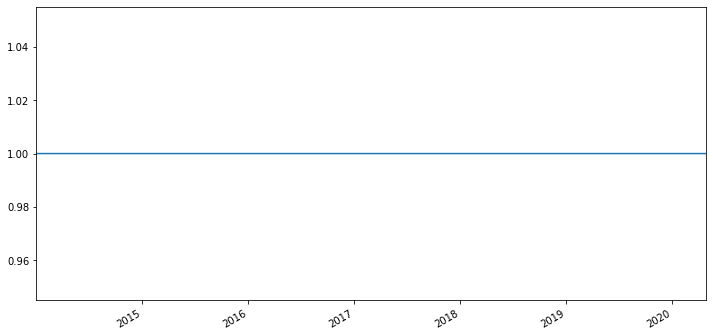

In [41]:
## Examine one of the crimes' time series
ts = TS['shooting']
ts.plot()

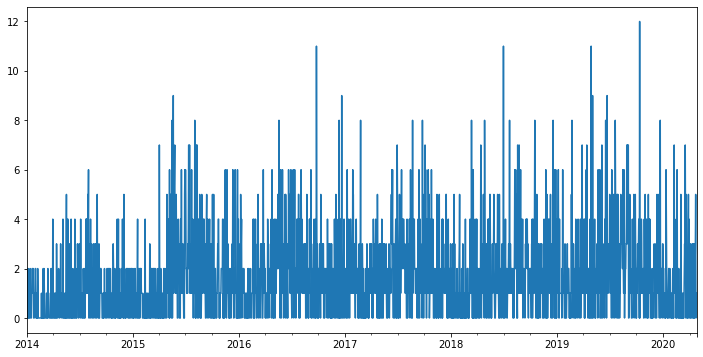

In [44]:
## Resample to daily data
ts = TS['shooting'].resample('D').sum()
ts.plot()

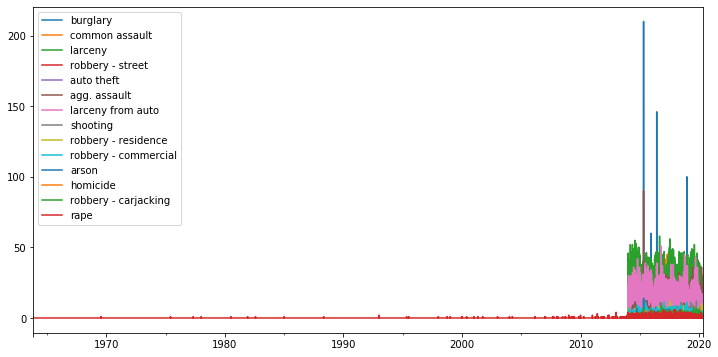

In [45]:
## Plot all crimes the same way
fig, ax = plt.subplots()
for crime,ts in TS.items():
    ts.resample('D').sum().plot(label=crime)
    
ax.legend()

### Slicing With Time Series

- Make sure you're index is sorted first'
- Feed in 2 dates as strings for slicing.
- Always use .loc when slicing dates

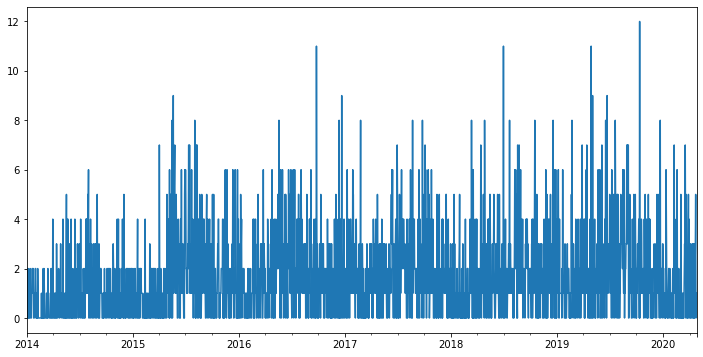

In [51]:
## Sort index
ts = TS['shooting'].resample('D').sum()
ts.loc['2014':].plot()

//anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning:

Attempting to set identical left == right == 16071.0 results in singular transformations; automatically expanding.



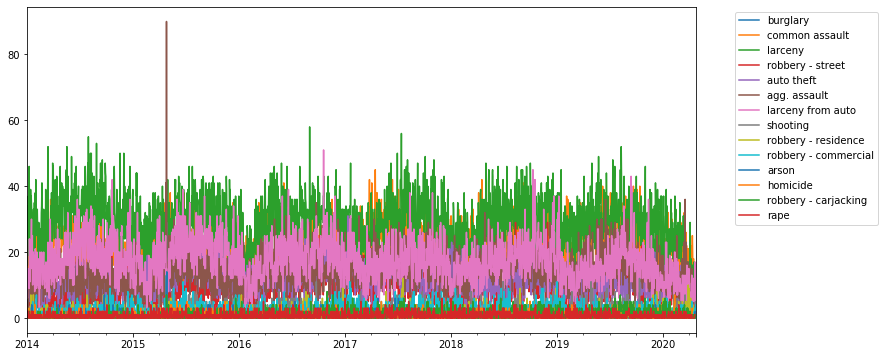

In [58]:
## Plot all crimes the same way
fig, ax = plt.subplots()
for crime,ts in TS.items():
    TS[crime] = ts.loc['2014':].resample('D').sum()
    TS[crime].plot(label=crime)
    
ax.legend(bbox_to_anchor=(1.05,1),loc='upper left')

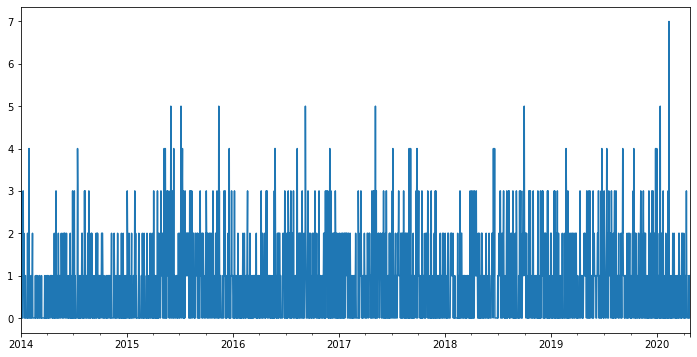

In [61]:
ts = TS['homicide']
ts.plot()

## Time series Frequencies


In [62]:
ts.index

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
               '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23'],
              dtype='datetime64[ns]', length=2305, freq='D')

In [63]:
# ts.isna().sum()


0

### Pandas Frequency Aliases


https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases


|Alias	| Description|
| --- | --- |
|B |	business day frequency|
|C |	custom business day frequency|
|D |	calendar day frequency|
|W |	weekly frequency|
|M |	month end frequency|
|SM |	semi-month end frequency (15th and end of month)|
|BM |	business month end frequency|
|CBM |	custom business month end frequency|
|MS |	month start frequency|
|SMS |	semi-month start frequency (1st and 15th)|
|BMS |	business month start frequency|
|CBMS |	custom business month start frequency|
|Q |	quarter end frequency|
|BQ |	business quarter end frequency|
|QS |	quarter start frequency|
|BQS |	business quarter start frequency|
|A, Y |	year end frequency|
|BA, BY |	business year end frequency|
|AS, YS |	year start frequency|
|BAS, BYS |	business year start frequency|
|BH | business hour frequency|
|H | hourly frequency|
|T |  min	minutely frequency|
|S | secondly frequency|
|L |  ms	milliseconds|
|U |  us	microseconds|
|N | nanoseconds|

In [66]:
import warnings
warnings.filterwarnings('ignore')

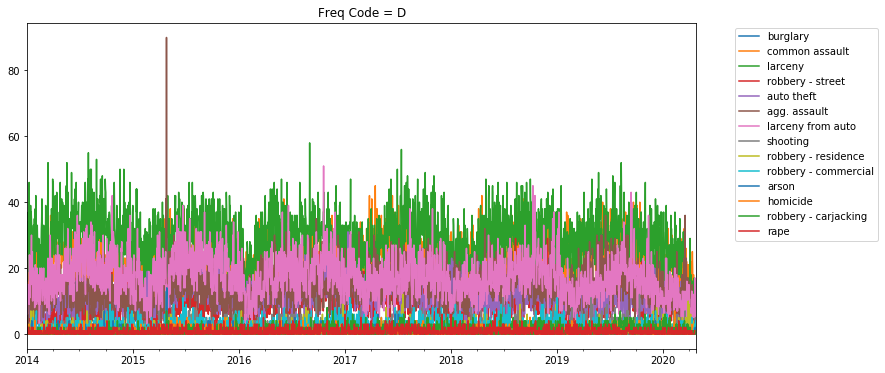

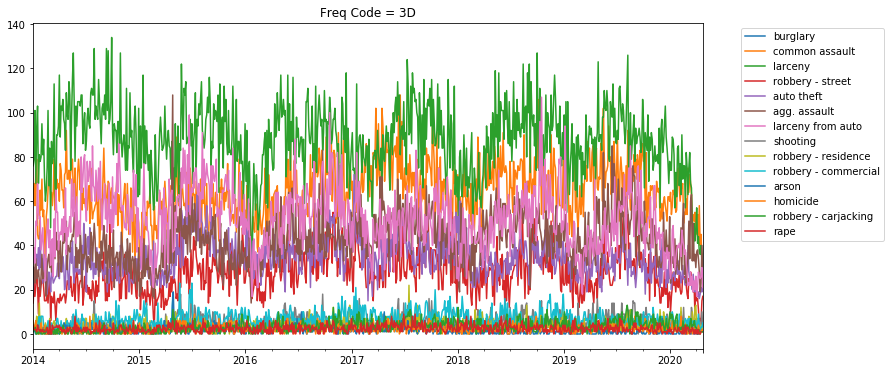

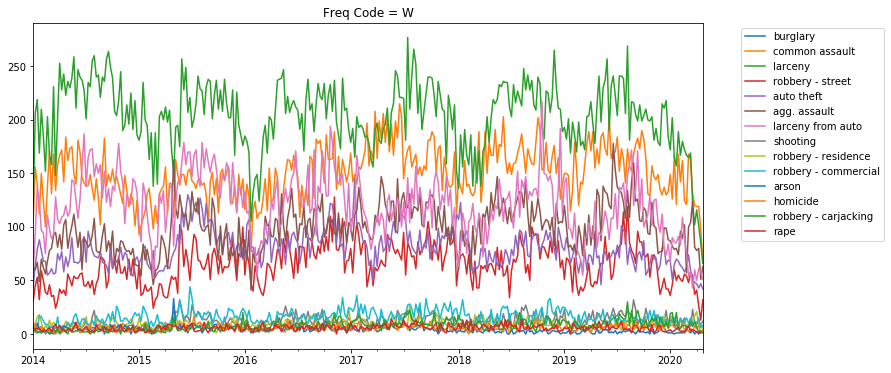

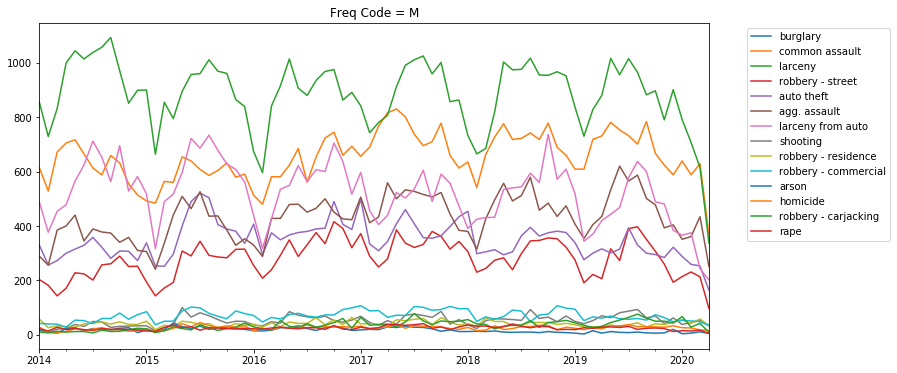

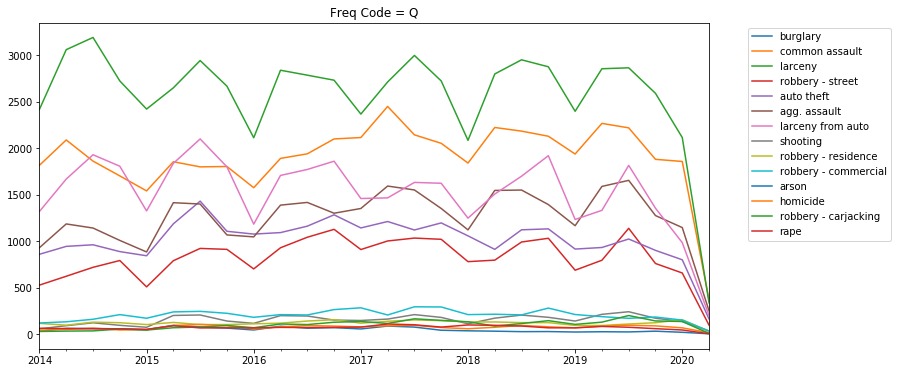

In [71]:
## Plot the same ts as different frequencies
freq_codes = ['D','3D','W','M','Q']

for freq in freq_codes:
    plt.figure()
    title= f"Freq Code = {freq}"
    ax = plt.gca()
    for crime,ts in TS.items():
        ts.resample(freq).sum().plot(title=title)
        
    ax.legend(bbox_to_anchor=(1.05,1),loc='upper left')

## Using Datetime objects and apply statemements

In [73]:
df_ = CRIMES['homicide']
display(df_.head())
df_.dtypes

,District,Longitude,Latitude,homicide
2020-04-23 09:29:00,NORTHWEST,-76.691827,39.319130,1
2020-04-22 00:49:00,SOUTHWEST,-76.683427,39.283381,1
2020-04-21 17:05:00,NORTHERN,-76.596828,39.355719,1
2020-04-19 00:17:00,WESTERN,-76.660548,39.313658,1
2020-04-12 19:43:00,NORTHWEST,-76.682679,39.326125,1


District      object
Longitude    float64
Latitude     float64
homicide       int64
dtype: object

In [96]:
df_.index.to_series().dt.year.strftime('%y')

AttributeError: 'Series' object has no attribute 'strftime'

In [98]:
df_.index.to_series().apply(lambda x: x.strftime('%y'))

ValueError: NaTType does not support strftime

In [95]:
test = df_.index.to_series()[0]
test.strftime('%y')

'20'

In [81]:
help(test)

Help on Timestamp in module pandas._libs.tslibs.timestamps object:

class Timestamp(pandas._libs.tslibs.c_timestamp._Timestamp)
 |  Pandas replacement for python datetime.datetime object.
 |  
 |  Timestamp is the pandas equivalent of python's Datetime
 |  and is interchangeable with it in most cases. It's the type used
 |  for the entries that make up a DatetimeIndex, and other timeseries
 |  oriented data structures in pandas.
 |  
 |  Parameters
 |  ----------
 |  ts_input : datetime-like, str, int, float
 |      Value to be converted to Timestamp.
 |  freq : str, DateOffset
 |      Offset which Timestamp will have.
 |  tz : str, pytz.timezone, dateutil.tz.tzfile or None
 |      Time zone for time which Timestamp will have.
 |  unit : str
 |      Unit used for conversion if ts_input is of type int or float. The
 |      valid values are 'D', 'h', 'm', 's', 'ms', 'us', and 'ns'. For
 |      example, 's' means seconds and 'ms' means milliseconds.
 |  year, month, day : int
 |      .. v

In [ ]:
# t = df.index.to_series()[0]
# display(t)
# print(t)

In [ ]:
# help(t.strptime)

### Date Str Formatting




Formatting follows the Python datetime <strong><a href='http://strftime.org/'>strftime</a></strong> codes.<br>
The following examples are based on <tt>datetime.datetime(2001, 2, 3, 16, 5, 6)</tt>:
<br><br>

<table style="display: inline-block">  
<tr><th>CODE</th><th>MEANING</th><th>EXAMPLE</th><tr>
<tr><td>%Y</td><td>Year with century as a decimal number.</td><td>2001</td></tr>
<tr><td>%y</td><td>Year without century as a zero-padded decimal number.</td><td>01</td></tr>
<tr><td>%m</td><td>Month as a zero-padded decimal number.</td><td>02</td></tr>
<tr><td>%B</td><td>Month as locale’s full name.</td><td>February</td></tr>
<tr><td>%b</td><td>Month as locale’s abbreviated name.</td><td>Feb</td></tr>
<tr><td>%d</td><td>Day of the month as a zero-padded decimal number.</td><td>03</td></tr>  
<tr><td>%A</td><td>Weekday as locale’s full name.</td><td>Saturday</td></tr>
<tr><td>%a</td><td>Weekday as locale’s abbreviated name.</td><td>Sat</td></tr>
<tr><td>%H</td><td>Hour (24-hour clock) as a zero-padded decimal number.</td><td>16</td></tr>
<tr><td>%I</td><td>Hour (12-hour clock) as a zero-padded decimal number.</td><td>04</td></tr>
<tr><td>%p</td><td>Locale’s equivalent of either AM or PM.</td><td>PM</td></tr>
<tr><td>%M</td><td>Minute as a zero-padded decimal number.</td><td>05</td></tr>
<tr><td>%S</td><td>Second as a zero-padded decimal number.</td><td>06</td></tr>
</table>
<table style="display: inline-block">
<tr><th>CODE</th><th>MEANING</th><th>EXAMPLE</th><tr>
<tr><td>%#m</td><td>Month as a decimal number. (Windows)</td><td>2</td></tr>
<tr><td>%-m</td><td>Month as a decimal number. (Mac/Linux)</td><td>2</td></tr>
<tr><td>%#x</td><td>Long date</td><td>Saturday, February 03, 2001</td></tr>
<tr><td>%#c</td><td>Long date and time</td><td>Saturday, February 03, 2001 16:05:06</td></tr>
</table>  
    

In [100]:
print(test.strftime("%m-%d-%Y"))
print(test.strftime("%T"))

04-23-2020
09:29:00


# Time Series Trends

<img src="https://raw.githubusercontent.com/learn-co-students/dsc-removing-trends-online-ds-ft-100719/master/images/new_trendseasonal.png" width=80%>

### Stationarity

<div style="text-align:center;font-size:2em">Mean</div>
    
<img src="https://raw.githubusercontent.com/jirvingphd/dsc-types-of-trends-online-ds-ft-100719/master/images/new_mean_nonstationary.png" width=70%>
<br><br>
<div style="text-align:center;font-size:3em">Variance</div>
<img src="https://raw.githubusercontent.com/jirvingphd/dsc-types-of-trends-online-ds-ft-100719/master/images/new_cov_nonstationary.png" width=70%>
</div>

In [112]:
## Lab Function
def stationarity_check(TS,plot=True,col=None):
    """From: https://learn.co/tracks/data-science-career-v2/module-4-a-complete-data-science-project-using-multiple-regression/working-with-time-series-data/time-series-decomposition
    """
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller

    if col is not None:
        # Perform the Dickey Fuller Test
        dftest = adfuller(TS[col]) # change the passengers column as required 
    else:
        dftest=adfuller(TS)
 
    if plot:
        # Calculate rolling statistics
        rolmean = TS.rolling(window = 8, center = False).mean()
        rolstd = TS.rolling(window = 8, center = False).std()

        #Plot rolling statistics:
        fig = plt.figure(figsize=(12,6))
        orig = plt.plot(TS, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    dfoutput['sig'] = dfoutput['p-value']<.05
    print (dfoutput)
    
    return dfoutput
#     return dftest

Results of Dickey-Fuller Test:
Test Statistic                -1.781543e+01
p-value                        3.176697e-30
#Lags Used                     5.000000e+00
Number of Observations Used    2.295000e+03
Critical Value (1%)           -3.433203e+00
Critical Value (5%)           -2.862800e+00
Critical Value (10%)          -2.567441e+00
sig                            1.000000e+00
dtype: float64


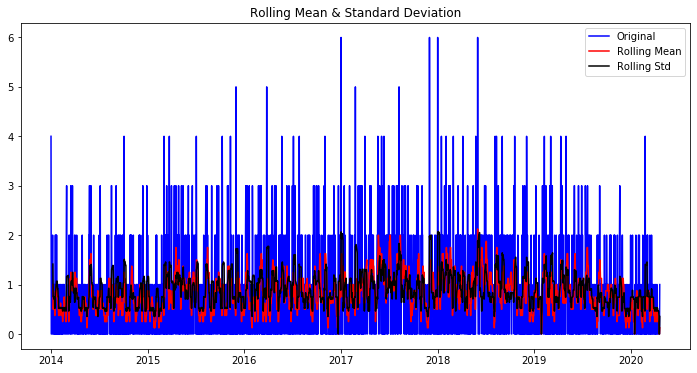

In [113]:
res = stationarity_check(ts);

In [106]:
res

(-17.815433751384507,
 3.176696966161389e-30,
 5,
 2295,
 {'1%': -3.433202561761398,
  '5%': -2.8628001971599955,
  '10%': -2.5674408601155303},
 6318.260704247796)

In [ ]:
ts_cleaned = ts_mean-ts_mean.rolling(7).mean()
ts_mean.plot()
ts_cleaned.plot()

### Types of Trends


- https://learn.co/tracks/data-science-career-v2/module-4-a-complete-data-science-project-using-multiple-regression/working-with-time-series-data/types-of-trends

### Removing Trends 
- .diff()
- subtract rolling mean
- seasonal decomposition

## Time Series Calculations


### Rolling Statistics

In [116]:
ts = TS['homicide']
ts

2014-01-01    2
2014-01-02    3
2014-01-03    1
2014-01-04    0
2014-01-05    0
             ..
2020-04-19    1
2020-04-20    0
2020-04-21    1
2020-04-22    1
2020-04-23    1
Freq: D, Name: homicide, Length: 2305, dtype: int64

In [123]:
ts = ts.resample('W').sum()
ts

2014-01-05     6
2014-01-12    10
2014-01-19     2
2014-01-26     2
2014-02-02     7
              ..
2020-03-29     7
2020-04-05     5
2020-04-12     8
2020-04-19     1
2020-04-26     3
Freq: W-SUN, Name: homicide, Length: 330, dtype: int64

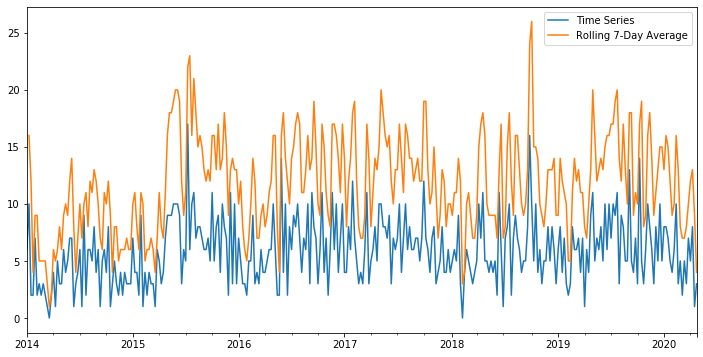

In [125]:
ts_mean = ts.rolling(window=2).sum()
ax = ts.plot(label='Time Series')
ts_mean.plot(label='Rolling 7-Day Average')
ax.legend()

In [131]:
## fill in null values
# ts.plot()
ts.ewm(halflife=2).sum()#.plot()

AttributeError: 'EWM' object has no attribute 'sum'

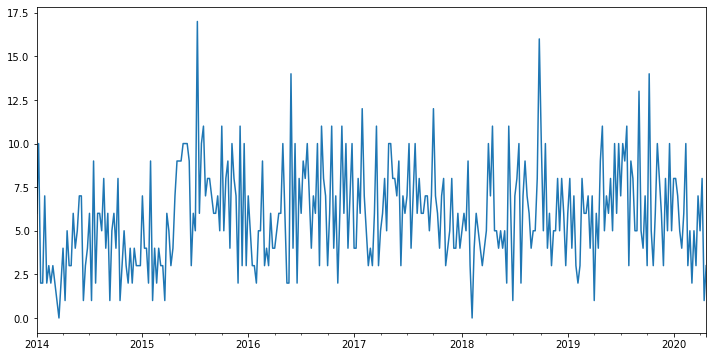

In [132]:
## Use adfull to test for stationarity
ts.plot()

# Seasonal Decomposition

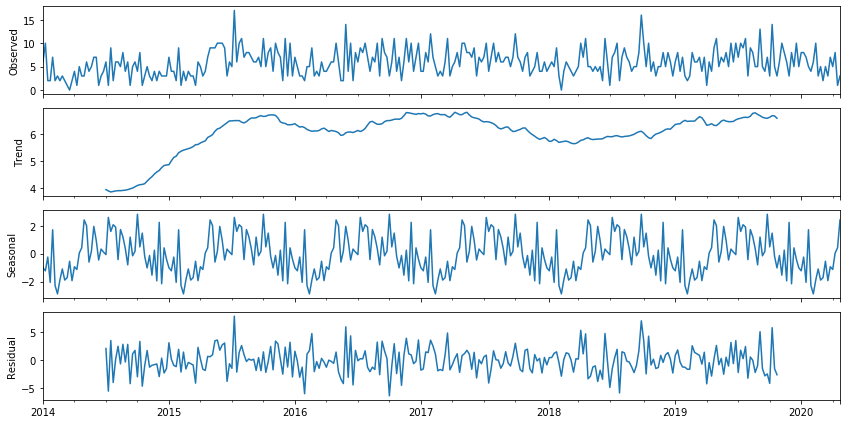

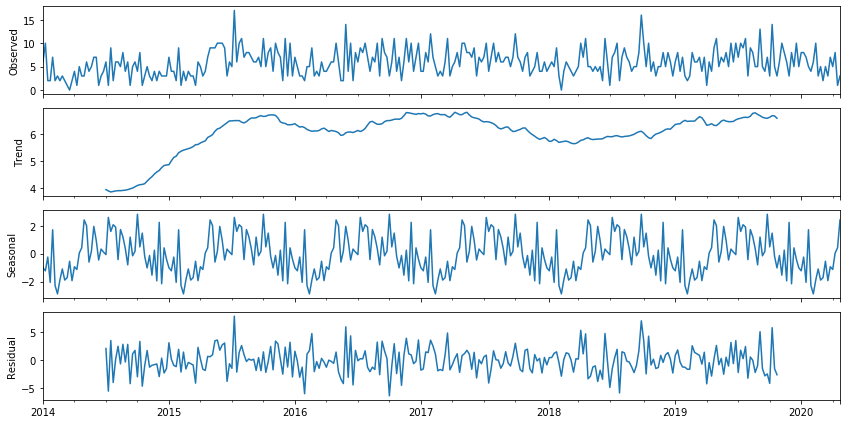

In [135]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(ts)#.plot();
decomp.plot()

In [137]:
decomp.resid

2014-01-05   NaN
2014-01-12   NaN
2014-01-19   NaN
2014-01-26   NaN
2014-02-02   NaN
              ..
2020-03-29   NaN
2020-04-05   NaN
2020-04-12   NaN
2020-04-19   NaN
2020-04-26   NaN
Freq: W-SUN, Name: homicide, Length: 330, dtype: float64

In [138]:
decomp.seasonal

2014-01-05   -1.009683
2014-01-12   -1.228914
2014-01-19   -0.242375
2014-01-26   -2.057760
2014-02-02    1.719163
                ...   
2020-03-29   -0.938529
2020-04-05   -1.134683
2020-04-12    0.049932
2020-04-19    0.421086
2020-04-26    2.421086
Freq: W-SUN, Name: homicide, Length: 330, dtype: float64

## A: Groupby Indexing

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c3cb5d5c0>],
      dtype=object)

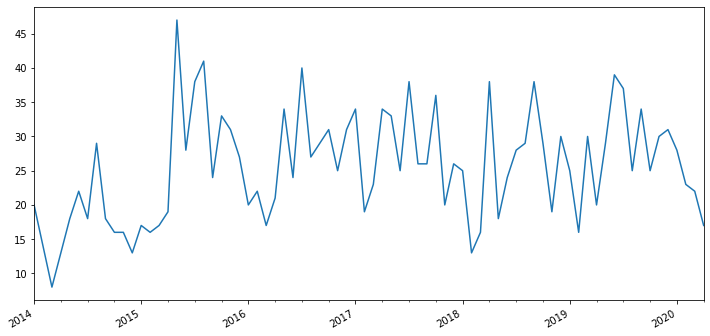

In [152]:
ts.groupby(pd.Grouper(freq='M')).sum().plot(subplots=True)

In [144]:
grp = list(CRIMES['shooting'].groupby('District'))
grp[0][0]

'CENTRAL'

In [145]:
grp[0][1]

,District,Longitude,Latitude,shooting
2020-04-25 16:09:00,CENTRAL,-76.623695,39.288378,1
2020-04-21 19:54:00,CENTRAL,-76.623695,39.288378,1
2020-03-30 16:03:00,CENTRAL,-76.631015,39.306280,1
2020-03-21 13:30:00,CENTRAL,-76.622389,39.291804,1
2020-03-17 18:27:00,CENTRAL,-76.628409,39.306977,1
...,...,...,...,...
2014-04-13 21:36:00,CENTRAL,-76.629327,39.306270,1
2014-03-01 20:16:00,CENTRAL,-76.632770,39.301938,1
2014-01-20 01:47:00,CENTRAL,-76.620813,39.288388,1
2014-01-19 00:49:00,CENTRAL,-76.610196,39.292432,1
